In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
import time
import timeit

In [4]:
print(timeit.timeit())
# print(time.time())

0.004385333973914385


In [13]:
X_test = None
y_test = None
with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test_10.pcl" , "rb") as f:
    X_test = pickle.load(f)

with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test_10.pcl", "rb")as f:
    y_test = pickle.load(f)

In [6]:
print(X_test.shape)
print(y_test.shape)

(556, 570, 33)
(556, 4)


In [14]:
X = np.empty((1, 570, 33, 1), dtype = float)
X[0,] = X_test[0]

In [15]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/keras_ecg_cnn_small_10.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
# print(input_shape.reshape(570,33,1))


[  1 570  33   1]


In [16]:
# inference
ret_results = []
for i,data in enumerate(X_test):  
    # print(data[i].reshape(540,33))
    # data = data.reshape(1,540,33,1)
    
    X = np.empty((1, 570, 33, 1), dtype = float)
    X[0,] = data
    start = timeit.timeit()
    input_data = X.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end = timeit.timeit()
    ret_results.append([start, end, y_test[i].argmax(), output_data.argmax()])

print(ret_results)
with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/small_10_pc_results.pcl", "wb") as f:
    pickle.dump(ret_results, f)

[[0.006441666046157479, 0.004784374963492155, 0, 3], [0.004702750011347234, 0.00439670798368752, 0, 0], [0.004362166044302285, 0.004234332940541208, 0, 0], [0.0043677909998223186, 0.004428042098879814, 0, 0], [0.004388541914522648, 0.0046891249949112535, 0, 0], [0.004394708084873855, 0.004512500017881393, 0, 0], [0.004397958051413298, 0.004484124947339296, 0, 0], [0.004475750029087067, 0.0043724169954657555, 0, 2], [0.00471316697075963, 0.004317583981901407, 0, 0], [0.004392333095893264, 0.004073500051163137, 0, 0], [0.004108250024728477, 0.004076499957591295, 0, 0], [0.004086917033419013, 0.00422637490555644, 0, 0], [0.004247499979101121, 0.004353167023509741, 0, 2], [0.00463612494058907, 0.00458470790181309, 0, 3], [0.004383249906823039, 0.006506958045065403, 0, 2], [0.0072472080355510116, 0.004529166966676712, 0, 0], [0.004504250013269484, 0.004177749971859157, 0, 0], [0.004086707951501012, 0.004504582961089909, 0, 3], [0.004096625023521483, 0.004246375057846308, 0, 0], [0.004089249

Accuracy:  0.7913669064748201


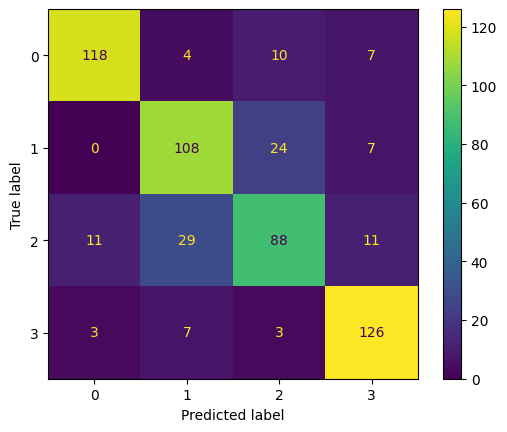

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = [i[3] for i in ret_results]
y_true = [i[2] for i in ret_results]
print("Accuracy: ", accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()